In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

**Environment**



In [ ]:
class MDPenvironment:
    def __init__(self, N):
        self.N = N
        self.S = self.generete_state_space()
        self.A = [a for a in range(N)]
        self.P = self.generate_markov_probabilities()
        self.r_stock = self.generate_stock_rewards()
        self.gamma = 0.9
        self.c = 0.01

    def reset(self):
        return random.randint(0,self.N-1)

    def get_binary_combinations(self):
        N = self.N
        B = {i: [] for i in range(2**N)}

        # Saving every combination of H/L given N
        for i in range(1 << N):
            i_b = format(i, '0' + str(N) + 'b')
            for j in range(N):
                B[i].append((1 if i_b[j] == '0' else 0))
        return B

    def generete_state_space(self):
        N = self.N
        S = {i: [] for i in range(N*np.power(2,N))}
        buffer = []
        B = self.get_binary_combinations()

        # State space creation

        # Getting all possible stocks we invest given the stock number
        for i in range(N):
            buffer.extend([i]*np.power(2,N))

        # Saving the these stocks as the first element of the list for each state
        for i in range(N*np.power(2,N)):
            S[i].append(buffer[i])

        # Getting all the different combinations of H/L for every stock played
        for i in range(N*np.power(2,N)):
            S[i].extend(B[i % np.power(2,N)])

        return S

    def generate_markov_probabilities(self):
        N = self.N
        P = np.zeros((N,4))

        if N == 2:        #pHH  pHL  pLH  pLL
            P = np.array([[0.65, 0.35, 0.1, 0.9],   #stock 0
                          [0.9, 0.1, 0.5, 0.5]])  #stock 1

        else:
            for i in range(N):
                if i< N/2 :
                    p_hl = 0.1
                    p_lh = 0.1

                else :
                    p_hl = 0.5
                    p_lh = 0.5

                P[i] = np.array([1-p_hl, p_hl, p_lh, 1-p_lh])

        return P.transpose()

    def generate_stock_rewards(self):
        N = self.N
        r = np.zeros((N,2))
        if N == 2:
            #              r_H    r_L
            r = np.array([[0.08, -0.03],
                          [0.04,  0.01]])
        else:
            for i in range(N):
                r[i][0] = np.random.uniform(-0.02, 0.1)
                r[i][1] = np.random.uniform(-0.02, 0.1)

        return r.transpose()

    def step(self, a, s):
        N = self.N
        states = self.S
        P = self.P
        r_stock = self.r_stock
        c = self.c
        current_stock = s[0]
        current_state = s[a + 1]

        s_prime = {i:states[k] for i,k in zip(range(np.power(2,N)),range(a*np.power(2,N),(a+1)*np.power(2,N)))}
        args_next = [k for k in range(a*np.power(2,N),(a+1)*np.power(2,N))]

        p = np.ones((np.power(2,N),))

        for i in range(np.power(2,N)):
            for n in range(N):
                if s[n+1] == 1 and s_prime[i][n+1] == 1:
                    p[i] *= P[0][n]
                elif s[n+1] == 1 and s_prime[i][n+1] == 0:
                    p[i] *= P[1][n]
                elif s[n+1] == 0 and s_prime[i][n+1] == 1:
                    p[i] *= P[2][n]
                else:
                    p[i] *= P[3][n]

        if a == current_stock:
            if current_state == 1:
                R = r_stock[0][a] * P[0][a] + r_stock[1][a] * P[1][a]
            else:
                R = r_stock[0][a] * P[2][a] + r_stock[1][a] * P[3][a]
        else:
            if current_state == 1:
                R = (r_stock[0][a] * P[0][a] + r_stock[1][a] * P[1][a]) - c
            else:
                R = (r_stock[0][a] * P[2][a] + r_stock[1][a] * P[3][a]) - c

        return p, args_next, R

**Model-Based Agent Algorithms**

In [ ]:
class Agent:
    def __init__(self, env):
        self.env = env

    def policy_evaluation(self, pi, epsilon):
        S = self.env.S
        A = self.env.A
        P = self.env.P
        R = self.env.r_stock
        gamma = self.env.gamma
        c = self.env.c
        self.cumulative_rewards = []

        V = np.zeros((len(S),))
        iteration = 0
        while True:
            delta = 0
            cumulative_gain = 0
            prev_V = V.copy()
            for sidx in range(len(S)):
                s = S[sidx]
                a = pi[sidx]
                p, sidx_next, r = self.env.step(a,s)
                V[sidx] = np.sum(p * (r + gamma * prev_V[sidx_next]))
                delta = np.max(np.abs(prev_V-V))

                cumulative_gain += V[sidx]
            self.cumulative_rewards.append(cumulative_gain)
            if  delta < epsilon:
                break
            iteration += 1
        return V

    def policy_improvement(self, V):
        S = self.env.S
        A = self.env.A
        P = self.env.P
        R = self.env.r_stock
        gamma = self.env.gamma
        c = self.env.c

        Q = np.zeros((len(S),len(A)), dtype=np.float64)

        for sidx in range(len(S)):
            s = S[sidx]
            for a in range(len(A)):
                p, sidx_next, r = self.env.step(a,s)
                Q[sidx][a] = np.sum(p*(r+gamma*V[sidx_next]))
        new_pi = {s: np.argmax(Q[s]) for s in range(len(S))}
        return new_pi

    def policy_iteration(self, epsilon):
        env = self.env
        A = env.A

        t = 0
        N = np.size(A)
        M = N*np.power(2,N)

        pi = {s: np.random.choice(A) for s in range(M)}
        while True:
            old_pi = pi.copy()
            V = self.policy_evaluation(pi,epsilon)
            pi = self.policy_improvement(V)
            t += 1
            if old_pi == pi:
                break
        return V, pi, t

    def plot_reward(self):
        plt.plot(self.cumulative_rewards)
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Reward')
        plt.show()

**Q-Learning (Model-Free) Agent Algorithms**

In [ ]:
class QLearningAgent:
    def __init__(self, env, alpha=0.2, episodes=1000):
        self.env = env
        self.alpha = alpha
        self.gamma = env.gamma
        self.epsilon = 1
        self.greedy_decay = 0.0095
        self.min_epsilon = 0.05
        self.max_epsilon = 1
        self.episodes = episodes
        self.Q = self.initialize_Q(env)
        self.accumulated_Q = []
        self.accumulated_reward = []

    def initialize_Q(self, env):
        size_S = len(env.S)
        size_A = len(env.A)
        return np.zeros((size_S, size_A), dtype=np.float64)

    def eGreedy(self, s):
        if random.uniform(0,1) < self.epsilon:
            return random.choice(self.env.A)
        else:
            return np.argmax(self.Q[s])

    def learn(self):

        for episode in range(self.episodes):
            sid = self.env.reset()
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.greedy_decay*episode)
            t = 0
            T_eff = np.ceil(1/(1-self.gamma))
            # Parameters for plotting
            total_reward = 0
            total_Q = 0

            while True:
                s = self.env.S[sid]
                a = self.eGreedy(sid)
                prob, sid_next, r = self.env.step(a,s)
                sid_prime = np.random.choice(sid_next, p = prob)

                gradient = r + self.gamma * np.max(self.Q[sid_prime]) - self.Q[sid][a]
                self.Q[sid][a] += self.alpha * gradient

                sid = sid_prime

                total_reward += r
                total_Q += self.Q[sid][a]

                t += 1
                if(t == 10*self.env.N*T_eff):
                    break

            self.accumulated_Q.append(total_Q)
            self.accumulated_reward.append(total_reward)

        return self.Q

    def get_policy(self):
        policy = {s: np.argmax(self.Q[s]) for s in range(len(self.env.S))}
        return policy

    def plot_reward(self):
        plt.plot(self.accumulated_Q, color='red', linewidth=0.8)
        plt.xlabel("Episode")
        plt.ylabel("Accumulated Q value")
        plt.show()
        plt.plot(self.accumulated_reward, color='blue', linewidth=0.8)
        plt.xlabel("Episode")
        plt.ylabel("Sum of rewards")
        plt.show()

**Deep Q-Network Agent**

In [ ]:
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, data):
        self.buffer.append(data)

    def sample(self, batch_size):
        states, actions, rewards, next_states = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states)

    def __len__(self):
        return len(self.buffer)

class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(DQNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.out = nn.Linear(hidden_dim,action_dim)

    def forward(self, input):
        z1 = self.fc1(input)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        a2 = F.relu(z2)
        return self.out(a2)

class DQNetworkAgent:
    def __init__(self, env, alpha=0.001, batch_size=64, episodes=1000, target_freq=50):
        self.env = env
        self.gamma = env.gamma
        self.alpha = alpha
        self.epsilon = 1
        self.greedy_decay = 0.0095
        self.min_epsilon = 0.05
        self.max_epsilon = 1
        self.episodes = episodes
        self.accumulated_reward = []

        self.batch_size = batch_size
        self.target_freq = target_freq
        self.D = ReplayBuffer(size=10000)
        # self.stock_market = ...

        self.Q_Network =  DQNetwork(self.env.N + 1, len(self.env.A))
        self.T_Network = DQNetwork(self.env.N + 1, len(self.env.A))
        self.T_Network.load_state_dict(self.Q_Network.state_dict())
        self.T_Network.eval()

        self.optimizer = torch.optim.SGD(self.Q_Network.parameters(), lr=self.alpha)
        self.cost = nn.MSELoss()
        self.loss = 0


    def eGreedy(self, sid):
        if random.uniform(0,1) < self.epsilon:
            return random.choice(self.env.A)
        else:
            state = torch.FloatTensor(self.env.S[sid])  # or state = x (stock holding + continuous values)
            Qvals = self.Q_Network(state)
            Qvals = Qvals.detach().numpy()
            return np.argmax(Qvals)

    def learning_step(self):
        if len(self.D) < self.batch_size:
            return

        states, actions, rewards, next_states = self.D.sample(self.batch_size)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)

        Q_values = self.Q_Network(states)   #(batch_size, N-d arrays)
        T_values = self.T_Network(next_states)
        max_T_values, _ = torch.max(T_values, dim=1)
        targets = rewards + self.gamma * max_T_values
        q = torch.gather(Q_values, 1, actions.unsqueeze(1)).squeeze(1)

        self.loss = self.cost(targets, q)

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()


    def learn(self):

        for episode in range(self.episodes):
            sid = self.env.reset()  # not needed if s = x (stock holding + continuous values)
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.greedy_decay*episode)
            T_eff = np.ceil(1/(1-self.gamma))
            t = 0
            total_reward = 0

            while True:
                s = self.env.S[sid] # or s = x (stock holding + continuous values)
                a = self.eGreedy(sid)
                prob, sid_next, r = self.env.step(a,s)  # reward chosesn through the action from our stocks table
                sid_prime = np.random.choice(sid_next, p = prob) # or s' = x'=[a, next_values of stocks]
                s_prime = self.env.S[sid_prime]

                self.D.add((s,a,r,s_prime))

                sid = sid_prime

                self.learning_step()

                total_reward += r

                if episode % self.target_freq == 0:
                    self.T_Network.load_state_dict(self.Q_Network.state_dict())

                t += 1
                if(t == 10*self.env.N*T_eff):
                    break

            self.accumulated_reward.append(total_reward)

            if (episode + 1) % 50 == 0:
                print(f"Episode {episode+1} | Reward = {total_reward}, Loss = {self.loss}")

    def get_policy(self):
        policy = {s: 0 for s in range(len(self.env.S))}
        for sid in range(len(self.env.S)):
            s = torch.FloatTensor(self.env.S[sid])
            Qvals = self.Q_Network(s)
            Qvals = Qvals.detach().numpy()
            policy[sid] = np.argmax(Qvals)
            return policy

    def plot_reward(self):
        plt.plot(self.accumulated_reward, color='blue', linewidth=0.8)
        plt.xlabel("Episode")
        plt.ylabel("Sum of rewards")
        plt.show()

**Main Program**

State Space: {0: [0, 1, 1, 1, 1], 1: [0, 1, 1, 1, 0], 2: [0, 1, 1, 0, 1], 3: [0, 1, 1, 0, 0], 4: [0, 1, 0, 1, 1], 5: [0, 1, 0, 1, 0], 6: [0, 1, 0, 0, 1], 7: [0, 1, 0, 0, 0], 8: [0, 0, 1, 1, 1], 9: [0, 0, 1, 1, 0], 10: [0, 0, 1, 0, 1], 11: [0, 0, 1, 0, 0], 12: [0, 0, 0, 1, 1], 13: [0, 0, 0, 1, 0], 14: [0, 0, 0, 0, 1], 15: [0, 0, 0, 0, 0], 16: [1, 1, 1, 1, 1], 17: [1, 1, 1, 1, 0], 18: [1, 1, 1, 0, 1], 19: [1, 1, 1, 0, 0], 20: [1, 1, 0, 1, 1], 21: [1, 1, 0, 1, 0], 22: [1, 1, 0, 0, 1], 23: [1, 1, 0, 0, 0], 24: [1, 0, 1, 1, 1], 25: [1, 0, 1, 1, 0], 26: [1, 0, 1, 0, 1], 27: [1, 0, 1, 0, 0], 28: [1, 0, 0, 1, 1], 29: [1, 0, 0, 1, 0], 30: [1, 0, 0, 0, 1], 31: [1, 0, 0, 0, 0], 32: [2, 1, 1, 1, 1], 33: [2, 1, 1, 1, 0], 34: [2, 1, 1, 0, 1], 35: [2, 1, 1, 0, 0], 36: [2, 1, 0, 1, 1], 37: [2, 1, 0, 1, 0], 38: [2, 1, 0, 0, 1], 39: [2, 1, 0, 0, 0], 40: [2, 0, 1, 1, 1], 41: [2, 0, 1, 1, 0], 42: [2, 0, 1, 0, 1], 43: [2, 0, 1, 0, 0], 44: [2, 0, 0, 1, 1], 45: [2, 0, 0, 1, 0], 46: [2, 0, 0, 0, 1], 47: [2, 0

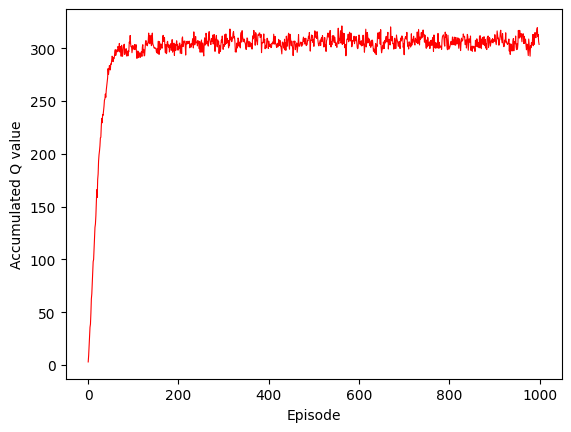

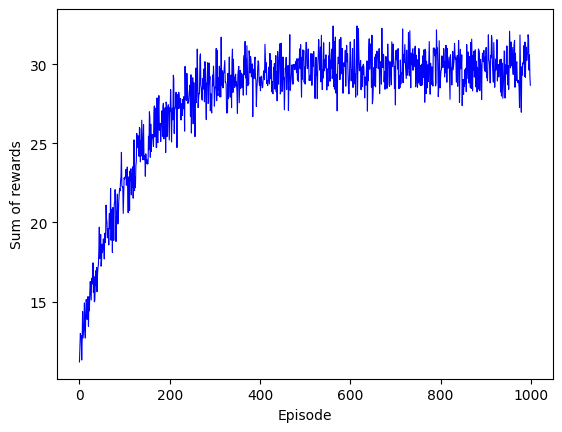

Deep Q-Network Agent

Episode 50 | Reward = 15.649876088183307, Loss = 0.000890868715941906
Episode 100 | Reward = 19.441594282450847, Loss = 0.0006269643199630082
Episode 150 | Reward = 24.34048714881641, Loss = 0.000429950887337327
Episode 200 | Reward = 25.02955610631121, Loss = 0.0011098049581050873
Episode 250 | Reward = 29.099587456445263, Loss = 0.0005892717163078487
Episode 300 | Reward = 28.8555525949549, Loss = 0.0006755419890396297
Episode 350 | Reward = 29.238700304258945, Loss = 0.0014990582130849361
Episode 400 | Reward = 29.678193884486916, Loss = 0.0007869965629652143
Episode 450 | Reward = 28.460185042161548, Loss = 0.0002893196069635451
Episode 500 | Reward = 29.389616515797414, Loss = 0.001033688778989017
Episode 550 | Reward = 29.25395920519405, Loss = 0.0011210617376491427
Episode 600 | Reward = 28.188271397101882, Loss = 0.0011846887646242976
Episode 650 | Reward = 30.647557638133108, Loss = 0.0008611753582954407
Episode 700 | Reward = 28.524766720530472, Loss = 0

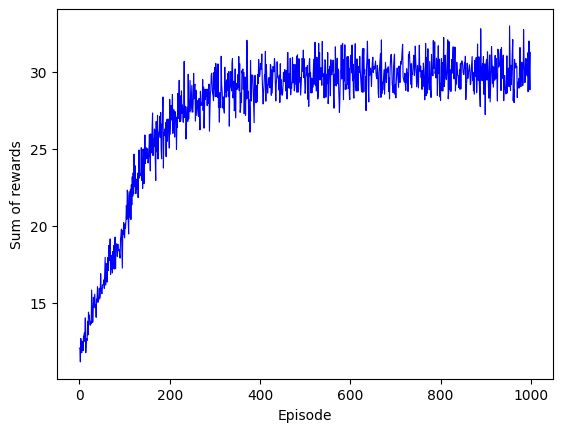

In [ ]:
if __name__ == '__main__':

    ################ Environment ################
    env = MDPenvironment(N=4)
    num = int(input("Press 1 if you want to see the Environment: "))
    if num == 1:
        print(f"State Space: {env.S} \n")
        print(f"Action Space: {env.A} \n")
        print(f"Markov Chain Probabilities: \n {env.P} \n")
        print(f"Markov Chain Rewards: \n {env.r_stock} \n")
        print(f"Discount Factor: {env.gamma} \n")
        print(f"Transaction fee: {env.c} \n")
    print("=======================================================================")

    ################ Model-Based Agent ################

    agent1 = Agent(env)
    V, pi1, t = agent1.policy_iteration(epsilon = 1e-10)

    print(f"Agent with full environment knowledge \n")
    if env.N < 4:
        for i in range(len(env.S)):
            print(f"For State {i} | Optimal policy pi(s) = {pi1[i]} | Expected Reward Gt = {V[i]} \n")
    else:
        print(f"PI policy evaluated.")
    print(f"PI Algorithm Iterations: {t}\n")
    print(f"{[pi1[i] for i in range(len(pi1))]}")
    print("=======================================================================")

    ################ Model-Free Agent ################
    agent2 = QLearningAgent(env)
    Q = agent2.learn()
    pi2 = agent2.get_policy()

    print(f"Q-Learning Agent\n")
    if env.N < 4:
        for i in range(len(env.S)):
            print(f"For State {i} | Optimal policy pi(s) = {pi2[i]} | Expected Reward Gt = {Q[i][pi2[i]]} \n")
    else:
        print(f"Q-Learning policy evaluated.")

    print(Q)

    print(f"PI policy {[pi1[i] for i in range(len(pi1))]}\nQL policy {[pi2[i] for i in range(len(pi2))]} \n")
    c = 0
    for i in range(len(env.S)):
        if pi1[i] == pi2[i]:
            c += 1
    print(f"Q-Learning Accuracy: {c/len(pi2)*100} %")
    print("=======================================================================")

    agent2.plot_reward()


    ################ Neural Network Agent ################
    print(f"Deep Q-Network Agent\n")
    agent3 = DQNetworkAgent(env)
    agent3.learn()
    pi3 = agent3.get_policy()

    print("=======================================================================")

    agent3.plot_reward()